In [24]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys

repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier, get_json_responses, SIMPLE_MODEL_POOL_CONFIG, TOKENS_PER_MILLION

In [25]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [26]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [56]:
def update_pricing_in_dataframe(df, model_name_col="model_name", input_token_col="total_input_tokens", output_token_col="total_output_tokens"):
    """
    Update pricing columns in a dataframe based on model_name and SIMPLE_MODEL_POOL_CONFIG.
    """
    for model_name in df[model_name_col].unique():
        if model_name not in SIMPLE_MODEL_POOL_CONFIG:
            print(f"Warning: {model_name} not found in SIMPLE_MODEL_POOL_CONFIG")
            continue
        
        input_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["input_per_mill"] / TOKENS_PER_MILLION
        output_cost = SIMPLE_MODEL_POOL_CONFIG[model_name]['model_costs']["output_per_mill"] / TOKENS_PER_MILLION
        
        mask = df[model_name_col] == model_name
        df.loc[mask, "input_cost_usd_once"] = df.loc[mask, input_token_col] * input_cost
        df.loc[mask, "total_output_cost_usd"] = df.loc[mask, output_token_col] * output_cost
        df.loc[mask, "total_cost_usd"] = df.loc[mask, "input_cost_usd_once"] + df.loc[mask, "total_output_cost_usd"]

In [28]:
# GENERATION_CONFIG
BASELINE_K=1
BASELINE_TEMP=0.0

PROBE_MODEL_DATA_SOURCE = "DigitalLearningGmbH_MATH-lighteval"
PROBE_PROBE_K=1
PROBE_PROBE_TEMP=0.0

ROUTING_MAX_K=1
ROUTING_TEMP=0.0
# ROUTER_OPTIONS="easy-3_hard-1_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-2_hard-4_medium-3_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5"
# ROUTER_OPTIONS="easy-8_hard-8_medium-8"
ROUTER_OPTIONS="greedy"

ROUTER_THRESHOLDS="E0.9_M0.4"
# ROUTER_THRESHOLDS="E0.8_M0.4"
# ROUTER_THRESHOLDS="E0.9_M0.3"

ROUTING_MODEL = "Qwen_Qwen2.5-Math-1.5B-Instruct"


Benchmark name: opencompass_AIME2025|| Router thresh: E0.9_M0.4
route_to
Qwen/Qwen2.5-Math-72B-Instruct    14
Qwen/Qwen2.5-Math-7B-Instruct      1
Name: count, dtype: int64


Benchmark name: gneubig_aime-1983-2024|| Router thresh: E0.9_M0.4
route_to
Qwen/Qwen2.5-Math-7B-Instruct      473
Qwen/Qwen2.5-Math-72B-Instruct     429
Qwen/Qwen2.5-Math-1.5B-Instruct     31
Name: count, dtype: int64


Benchmark name: openai_gsm8k|| Router thresh: E0.9_M0.4
route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    1012
Qwen/Qwen2.5-Math-7B-Instruct       305
Qwen/Qwen2.5-Math-72B-Instruct        2
Name: count, dtype: int64


Benchmark name: DigitalLearningGmbH_MATH-lighteval|| Router thresh: E0.9_M0.4
route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    2506
Qwen/Qwen2.5-Math-7B-Instruct      2041
Qwen/Qwen2.5-Math-72B-Instruct      453
Name: count, dtype: int64



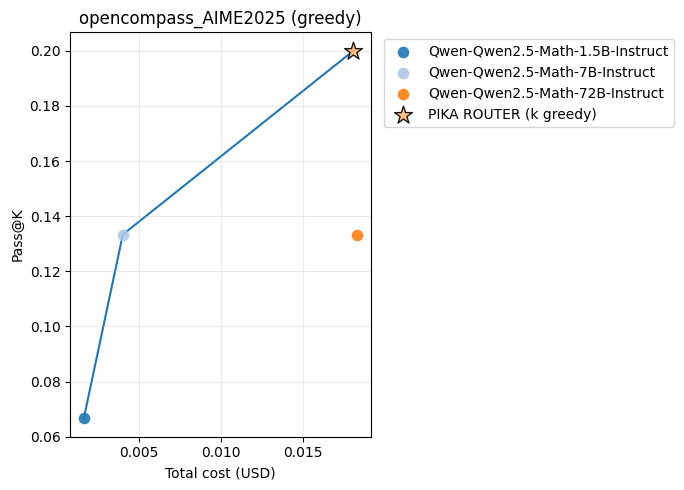

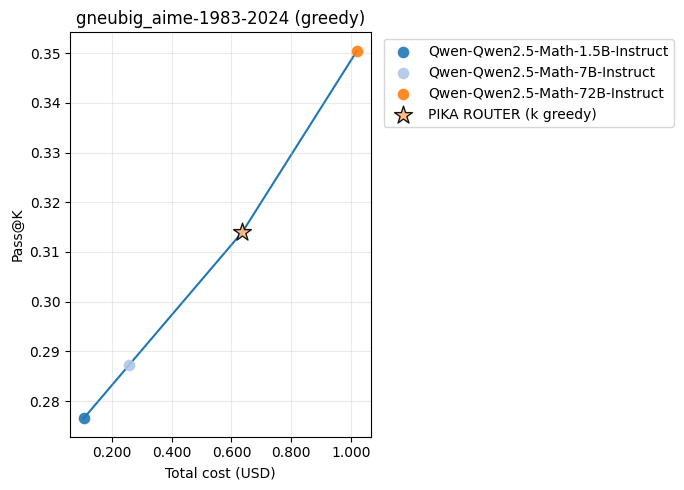

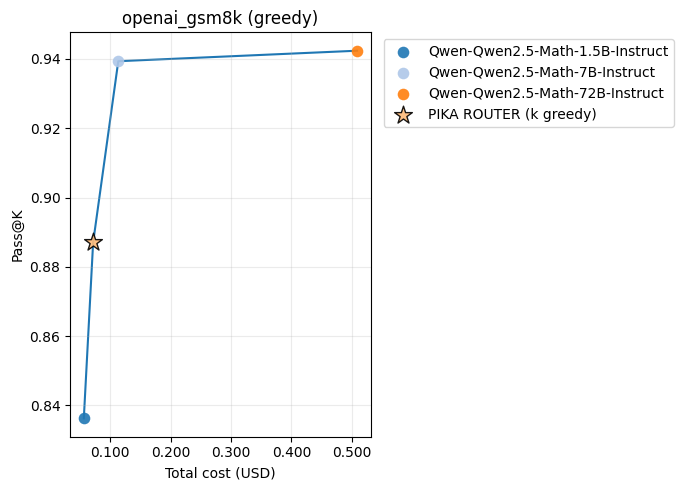

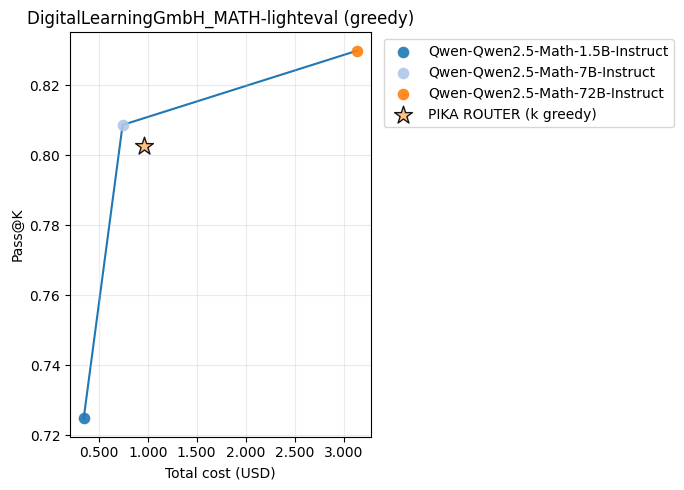

In [59]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)
        update_pricing_in_dataframe(BASELINE_BENCHMARK_DF)
        

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})

        
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS

    PIKA_V2_DIR = f"pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{PROBE_MODEL_DATA_SOURCE}_{ROUTING_MODEL}_probeK{PROBE_PROBE_K}_probeT{PROBE_PROBE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_{ROUTER_OPTIONS}_thresh{ROUTER_THRESHOLDS}.parquet"
    try:
        pika_df = pd.read_parquet(PIKA_V2_DIR)
        update_pricing_in_dataframe(pika_df, model_name_col="route_to", input_token_col="input_num_tokens", output_token_col="response_num_tokens")

        pika_sr_score = pika_df["passk_score"].mean()
        pika_majority_vote_score = pika_df["majority_vote_is_correct"].mean()
        pika_total_cost = pika_df["total_cost_usd"].sum()

        print('===============================\n')
        print(f"Benchmark name: {BASELINE_BENCHMARK_ALIAS}|| Router thresh: {ROUTER_THRESHOLDS}")
        print(pika_df['route_to'].value_counts())
        print('===============================\n')


        PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": f"PIKA ROUTER (k {ROUTER_OPTIONS})", "kind": "router", "passk_score": pika_sr_score, "majority_vote_score":pika_majority_vote_score, "cost": pika_total_cost}]
    except Exception as e:
        print(f"Router config doesn't exist: {e}")

for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += f" ({ROUTER_OPTIONS})"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")


In [30]:
SIMPLE_MODEL_POOL_CONFIG["Qwen/Qwen2.5-Math-72B-Instruct"]['model_costs']["input_per_mill"] /TOKENS_PER_MILLION * 68

6.120000000000001e-05

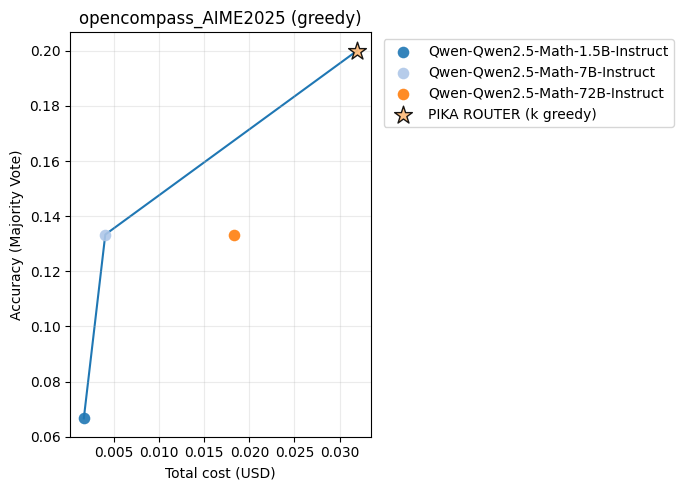

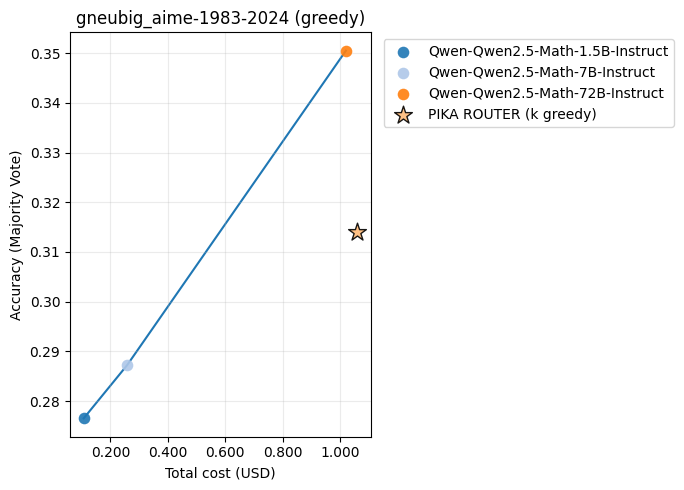

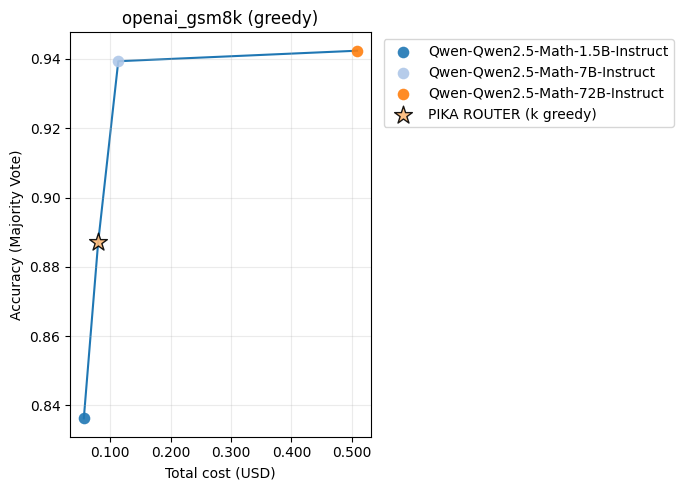

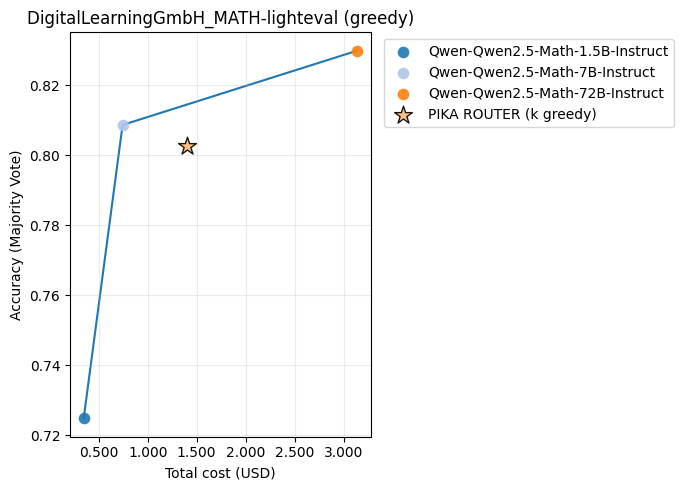

In [31]:
for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += " (greedy)"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K}) "
    plot_pareto_frontier(data_points, benchmark, score_col="majority_vote_score", x_label="Total cost (USD)", y_label=f"Accuracy (Majority Vote)")

In [32]:
pika_df["route_to"].value_counts()

route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    2506
Qwen/Qwen2.5-Math-7B-Instruct      2041
Qwen/Qwen2.5-Math-72B-Instruct      453
Name: count, dtype: int64

In [33]:
pika_df["route_to"].value_counts()

route_to
Qwen/Qwen2.5-Math-1.5B-Instruct    2506
Qwen/Qwen2.5-Math-7B-Instruct      2041
Qwen/Qwen2.5-Math-72B-Instruct      453
Name: count, dtype: int64

In [34]:
import json
json.loads(pika_df['generated_solutions'].iloc[0])

[{'text': 'To determine the number of vertical asymptotes of the function \\( y = \\frac{2}{x^2 + x - 6} \\), we need to identify the values of \\( x \\) that make the denominator zero, as these are the points where the function is undefined and potentially has vertical asymptotes.\n\nFirst, we factor the denominator \\( x^2 + x - 6 \\):\n\\[ x^2 + x - 6 = (x + 3)(x - 2). \\]\nSo, the function can be rewritten as:\n\\[ y = \\frac{2}{(x + 3)(x - 2)}. \\]\nThe vertical asymptotes occur where the denominator is zero, i.e., where \\( (x + 3)(x - 2) = 0 \\). This gives us two solutions:\n\\[ x + 3 = 0 \\quad \\text{or} \\quad x - 2 = 0, \\]\nwhich means:\n\\[ x = -3 \\quad \\text{or} \\quad x = 2. \\]\nThese are the points where the function is undefined and has vertical asymptotes. Therefore, the function \\( y = \\frac{2}{x^2 + x - 6} \\) has vertical asymptotes at \\( x = -3 \\) and \\( x = 2 \\).\n\nThus, the number of vertical asymptotes is \\(\\boxed{2}\\).',
  'output_tokens': 298,
 

In [35]:
aime_25_1p5b_df = pd.read_parquet(f"../will_replication/DATA/SR_DATA/opencompass_AIME2025/test-Qwen-Qwen2.5-Math-1.5B-Instruct_maxlen_3000_k_1_temp_0.0.parquet")
aime_25_7b_df = pd.read_parquet(f"../will_replication/DATA/SR_DATA/opencompass_AIME2025/test-Qwen-Qwen2.5-Math-7B-Instruct_maxlen_3000_k_1_temp_0.0.parquet")
aime_25_72b_df = pd.read_parquet(f"../will_replication/DATA/SR_DATA/opencompass_AIME2025/test-Qwen-Qwen2.5-Math-72B-Instruct_maxlen_3000_k_1_temp_0.0.parquet")

In [36]:
aime_25_72b_df["total_cost_usd"].sum()

0.032439885

In [37]:
def get_mean_output_tokens(gen_sol_obj):
    total_output_toks = 0
    for arr in gen_sol_obj:
        total_output_toks+=arr["output_tokens"]
    return total_output_toks/len(gen_sol_obj)

In [38]:
# Create boolean masks for majority vote correctness in each model
mask_1p5b = aime_25_1p5b_df['majority_vote_is_correct'] == 1.0
mask_7b = aime_25_7b_df['majority_vote_is_correct'] == 1.0
mask_72b = aime_25_72b_df['majority_vote_is_correct'] == 1.0

# Find problems where each model gets majority vote correct
problems_1p5b = set(aime_25_1p5b_df.loc[mask_1p5b, 'problem_id'])
problems_7b = set(aime_25_7b_df.loc[mask_7b, 'problem_id'])
problems_72b = set(aime_25_72b_df.loc[mask_72b, 'problem_id'])


# Create a DataFrame comparing correctness
comparison_df = pd.DataFrame({
    'problem_id': aime_25_1p5b_df['problem_id'],
    'majority_vote_1p5b': aime_25_1p5b_df['majority_vote_is_correct'],
    'majority_vote_7b': aime_25_7b_df['majority_vote_is_correct'],
    'majority_vote_72b': aime_25_72b_df['majority_vote_is_correct'],

    'correct_1p5b_only': aime_25_1p5b_df['problem_id'].isin(problems_1p5b - problems_7b - problems_72b),
    'correct_7b_only': aime_25_1p5b_df['problem_id'].isin(problems_7b - problems_1p5b - problems_72b),
    'correct_72b_only': aime_25_1p5b_df['problem_id'].isin(problems_72b - problems_1p5b - problems_7b),

    'correct_1p5b_7b': aime_25_1p5b_df['problem_id'].isin((problems_1p5b & problems_7b) - problems_72b),
    'correct_1p5b_72b': aime_25_1p5b_df['problem_id'].isin((problems_1p5b & problems_72b) - problems_7b),
    'correct_7b_72b': aime_25_1p5b_df['problem_id'].isin((problems_7b & problems_72b) - problems_1p5b),

    'all_correct': aime_25_1p5b_df['problem_id'].isin(problems_1p5b & problems_7b & problems_72b),

    '1p5b_passk': aime_25_1p5b_df["success_rate"],
    '7b_passk': aime_25_7b_df["success_rate"],
    '72b_passk': aime_25_72b_df["success_rate"],
    "ground_truth": aime_25_7b_df["ground_truth"],
    "1p5b_generated_solutions": aime_25_1p5b_df["generated_solutions"],
    "7b_generated_solutions": aime_25_7b_df["generated_solutions"],
    "72b_generated_solutions": aime_25_72b_df["generated_solutions"],
})
comparison_df["1p5b_mean_sol_lengths"] = comparison_df["1p5b_generated_solutions"].apply(lambda x: get_mean_output_tokens(x))
comparison_df["7b_mean_sol_lengths"] = comparison_df["7b_generated_solutions"].apply(lambda x: get_mean_output_tokens(x))
comparison_df["72b_mean_sol_lengths"] = comparison_df["72b_generated_solutions"].apply(lambda x: get_mean_output_tokens(x))

comparison_df

,problem_id,majority_vote_1p5b,majority_vote_7b,majority_vote_72b,correct_1p5b_only,correct_7b_only,correct_72b_only,correct_1p5b_7b,correct_1p5b_72b,correct_7b_72b,...,1p5b_passk,7b_passk,72b_passk,ground_truth,1p5b_generated_solutions,7b_generated_solutions,72b_generated_solutions,1p5b_mean_sol_lengths,7b_mean_sol_lengths,72b_mean_sol_lengths
0,RmluZCB0aGUgc3VtIG9mIGFsbCBpbnRlZ2VyIGJhc2VzIC...,0.0,1.0,0.0,False,True,False,False,False,False,...,0.0,1.0,0.0,70,"[{'input_cost_usd_once': 7.4e-06, 'input_token...","[{'input_cost_usd_once': 1.0656e-05, 'input_to...","[{'input_cost_usd_once': 4.2476e-05, 'input_to...",773.0,1455.0,743.0
1,T24gJFx0cmlhbmdsZSBBQkMkIHBvaW50cyAkQSxELEUkLC...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,588,"[{'input_cost_usd_once': 1.84e-05, 'input_toke...","[{'input_cost_usd_once': 2.6496e-05, 'input_to...",[{'input_cost_usd_once': 0.0001056159999999999...,708.0,3000.0,1068.0
2,VGhlIDkgbWVtYmVycyBvZiBhIGJhc2ViYWxsIHRlYW0gd2...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,16,[{'input_cost_usd_once': 1.5300000000000003e-0...,"[{'input_cost_usd_once': 2.2032e-05, 'input_to...","[{'input_cost_usd_once': 8.7822e-05, 'input_to...",708.0,819.0,919.0
3,RmluZCB0aGUgbnVtYmVyIG9mIG9yZGVyZWQgcGFpcnMgJC...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,117,[{'input_cost_usd_once': 9.800000000000001e-06...,[{'input_cost_usd_once': 1.4111999999999998e-0...,[{'input_cost_usd_once': 5.6251999999999996e-0...,799.0,670.0,950.0
4,VGhlcmUgYXJlICQ4IT00MDMyMCQgZWlnaHQtZGlnaXQgcG...,0.0,0.0,1.0,False,False,True,False,False,False,...,0.0,0.0,1.0,279,"[{'input_cost_usd_once': 1.16e-05, 'input_toke...",[{'input_cost_usd_once': 1.6703999999999998e-0...,"[{'input_cost_usd_once': 6.6584e-05, 'input_to...",1177.0,723.0,1344.0
5,QW4gaXNvc2NlbGVzIHRyYXBlem9pZCBoYXMgYW4gaW5zY3...,1.0,1.0,1.0,False,False,False,False,False,False,...,1.0,1.0,1.0,504,"[{'input_cost_usd_once': 1.27e-05, 'input_toke...","[{'input_cost_usd_once': 1.8288e-05, 'input_to...",[{'input_cost_usd_once': 7.289799999999999e-05...,961.0,1375.0,975.0
6,VGhlIHR3ZWx2ZSBsZXR0ZXJzICRBLEIsQyxELEUsRixHLE...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,821,"[{'input_cost_usd_once': 1.62e-05, 'input_toke...","[{'input_cost_usd_once': 2.3328e-05, 'input_to...","[{'input_cost_usd_once': 9.2988e-05, 'input_to...",568.0,350.0,371.0
7,TGV0ICRrJCBiZSByZWFsIG51bWJlcnMgc3VjaCB0aGF0IH...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,77,[{'input_cost_usd_once': 1.3899999999999999e-0...,[{'input_cost_usd_once': 2.0015999999999996e-0...,[{'input_cost_usd_once': 7.978599999999998e-05...,1272.0,1902.0,3000.0
8,VGhlIHBhcmFib2xhIHdpdGggZXF1YXRpb24gJHk9eF57Mn...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,62,[{'input_cost_usd_once': 1.4300000000000002e-0...,"[{'input_cost_usd_once': 2.0592e-05, 'input_to...",[{'input_cost_usd_once': 8.208199999999999e-05...,1095.0,1919.0,1484.0
9,VGhlIDI3IGNlbGxzIG9mIGEgJDNcdGltZXM5JCBncmlkIG...,0.0,0.0,0.0,False,False,False,False,False,False,...,0.0,0.0,0.0,81,"[{'input_cost_usd_once': 2.83e-05, 'input_toke...","[{'input_cost_usd_once': 4.0752e-05, 'input_to...",[{'input_cost_usd_once': 0.0001624419999999999...,895.0,1005.0,856.0


In [39]:
comparison_df["72b_generated_solutions"].iloc[0]

array([{'input_cost_usd_once': 4.2476e-05, 'input_tokens': 74, 'output_cost_usd': 0.001278703, 'output_tokens': 743, 'rollout_cost_usd': 0.001278703, 'score': 0.0, 'text': "To find the sum of all integer bases \\( b > 9 \\) for which \\( 17_b \\) is a divisor of \\( 97_b \\), we first need to convert these numbers from base \\( b \\) to base 10.\n\nThe number \\( 17_b \\) in base 10 is \\( 1 \\cdot b + 7 = b + 7 \\).\nThe number \\( 97_b \\) in base 10 is \\( 9 \\cdot b + 7 = 9b + 7 \\).\n\nWe need to find the values of \\( b \\) such that \\( b + 7 \\) divides \\( 9b + 7 \\). This means that there exists an integer \\( k \\) such that:\n\\[ 9b + 7 = k(b + 7). \\]\n\nRearranging the equation, we get:\n\\[ 9b + 7 = kb + 7k, \\]\n\\[ 9b - kb = 7k - 7, \\]\n\\[ b(9 - k) = 7(k - 1). \\]\n\nSolving for \\( b \\), we obtain:\n\\[ b = \\frac{7(k - 1)}{9 - k}. \\]\n\nSince \\( b \\) is a positive integer, \\( 9 - k \\) must be a positive divisor of \\( 7(k - 1) \\). Also, \\( k \\) must be les

In [40]:
comparison_df["7b_passk"].mean(), comparison_df["majority_vote_7b"].mean()

(0.13333333333333333, 0.13333333333333333)

In [41]:
comparison_df["72b_passk"].mean(), comparison_df["majority_vote_72b"].mean()

(0.13333333333333333, 0.13333333333333333)

In [42]:
comparison_df["1p5b_mean_sol_lengths"] = comparison_df["1p5b_generated_solutions"].apply(lambda x: get_mean_output_tokens(x))
comparison_df["7b_mean_sol_lengths"] = comparison_df["7b_generated_solutions"].apply(lambda x: get_mean_output_tokens(x))

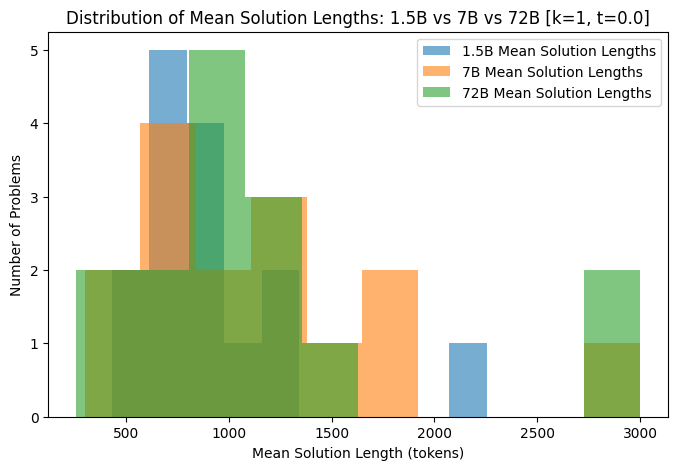

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(comparison_df["1p5b_mean_sol_lengths"], bins=10, alpha=0.6, label="1.5B Mean Solution Lengths")
plt.hist(comparison_df["7b_mean_sol_lengths"], bins=10, alpha=0.6, label="7B Mean Solution Lengths")
plt.hist(comparison_df["72b_mean_sol_lengths"], bins=10, alpha=0.6, label="72B Mean Solution Lengths")
plt.xlabel("Mean Solution Length (tokens)")
plt.ylabel("Number of Problems")
plt.title("Distribution of Mean Solution Lengths: 1.5B vs 7B vs 72B [k=1, t=0.0]")
plt.legend()
plt.show()

In [44]:
comparison_df["1p5b_generated_solutions"].iloc[0]

array([{'input_cost_usd_once': 7.4e-06, 'input_tokens': 74, 'output_cost_usd': 7.730000000000001e-05, 'output_tokens': 773, 'rollout_cost_usd': 7.730000000000001e-05, 'score': 0.0, 'text': 'To determine the sum of all integer bases \\( b > 9 \\) for which \\( 17_b \\) is a divisor of \\( 97_b \\), we first need to convert these numbers from base \\( b \\) to base 10.\n\nThe number \\( 17_b \\) in base 10 is:\n\\[\n17_b = 1 \\cdot b + 7 = b + 7\n\\]\n\nThe number \\( 97_b \\) in base 10 is:\n\\[\n97_b = 9 \\cdot b + 7 = 9b + 7\n\\]\n\nWe need \\( 17_b \\) to be a divisor of \\( 97_b \\). This means that \\( b + 7 \\) must divide \\( 9b + 7 \\). We can express this condition as:\n\\[\n9b + 7 = k(b + 7)\n\\]\nfor some integer \\( k \\). Expanding and rearranging terms, we get:\n\\[\n9b + 7 = kb + 7k \\implies 9b - kb = 7k - 7 \\implies b(9 - k) = 7(k - 1)\n\\]\nThis implies:\n\\[\nb = \\frac{7(k - 1)}{9 - k}\n\\]\nSince \\( b \\) is an integer, \\( \\frac{7(k - 1)}{9 - k} \\) must be an i

In [45]:
comparison_df["7b_generated_solutions"].iloc[0]

array([{'input_cost_usd_once': 1.0656e-05, 'input_tokens': 74, 'output_cost_usd': 0.00041758499999999994, 'output_tokens': 1455, 'rollout_cost_usd': 0.00041758499999999994, 'score': 1.0, 'text': 'To determine the sum of all integer bases \\( b > 9 \\) for which \\( 17_b \\) is a divisor of \\( 97_b \\), we start by converting the base \\( b \\) numbers to base 10. The base \\( b \\) number \\( 17_b \\) can be expressed as:\n\\[\n17_b = 1 \\cdot b + 7 = b + 7\n\\]\nSimilarly, the base \\( b \\) number \\( 97_b \\) can be expressed as:\n\\[\n97_b = 9 \\cdot b + 7 = 9b + 7\n\\]\nWe need to find the values of \\( b \\) such that \\( b + 7 \\) divides \\( 9b + 7 \\). This means that there exists an integer \\( k \\) such that:\n\\[\n9b + 7 = k(b + 7)\n\\]\nRearranging the equation, we get:\n\\[\n9b + 7 = kb + 7k \\implies 9b - kb = 7k - 7 \\implies b(9 - k) = 7(k - 1)\n\\]\nSolving for \\( b \\), we have:\n\\[\nb = \\frac{7(k - 1)}{9 - k}\n\\]\nSince \\( b \\) is an integer, \\( 9 - k \\) m

In [46]:
comparison_df["7b_generated_solutions"].iloc[0][0]

{'input_cost_usd_once': 1.0656e-05,
 'input_tokens': 74,
 'output_cost_usd': 0.00041758499999999994,
 'output_tokens': 1455,
 'rollout_cost_usd': 0.00041758499999999994,
 'score': 1.0,
 'text': 'To determine the sum of all integer bases \\( b > 9 \\) for which \\( 17_b \\) is a divisor of \\( 97_b \\), we start by converting the base \\( b \\) numbers to base 10. The base \\( b \\) number \\( 17_b \\) can be expressed as:\n\\[\n17_b = 1 \\cdot b + 7 = b + 7\n\\]\nSimilarly, the base \\( b \\) number \\( 97_b \\) can be expressed as:\n\\[\n97_b = 9 \\cdot b + 7 = 9b + 7\n\\]\nWe need to find the values of \\( b \\) such that \\( b + 7 \\) divides \\( 9b + 7 \\). This means that there exists an integer \\( k \\) such that:\n\\[\n9b + 7 = k(b + 7)\n\\]\nRearranging the equation, we get:\n\\[\n9b + 7 = kb + 7k \\implies 9b - kb = 7k - 7 \\implies b(9 - k) = 7(k - 1)\n\\]\nSolving for \\( b \\), we have:\n\\[\nb = \\frac{7(k - 1)}{9 - k}\n\\]\nSince \\( b \\) is an integer, \\( 9 - k \\) mu